In [1]:
import sqlite3
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hier




In [2]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [3]:
import sqlite3

values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    # print(row)
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))
    

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0


    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue


    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        # print(sprat)
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)


    # print(row)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    # else:
    #     break
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])

    cena = float(row[16])
    # , legal, air_c, elevator, garage

    row_x_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv]
    row_full_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

In [4]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
# new_header = ['distance', 'kvadratura', 'broj_soba']
new_header = ['distance', 'kvadratura', 'broj_soba']

df_x = pd.DataFrame(X_data, columns=header)

X_data_new = df_x[new_header] 


C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

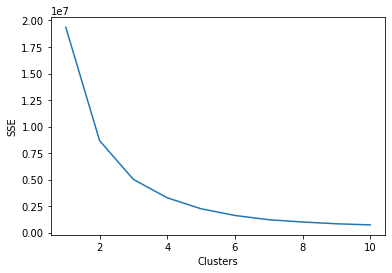

In [5]:
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X_data_new)
    wcss.append(k_means.inertia_)
#plot elbow curve
plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [6]:
k_means_optimum = KMeans(n_clusters = 3, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X_data_new)
# print(y)
X_data_new['cluster'] = y  


C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\busketi\AppData\Local\Temp/ipykernel_22544/1117952808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data_new['cluster'] = y


In [7]:
data1 = X_data_new[X_data_new.cluster==0]
data2 = X_data_new[X_data_new.cluster==1]
data3 = X_data_new[X_data_new.cluster==2]

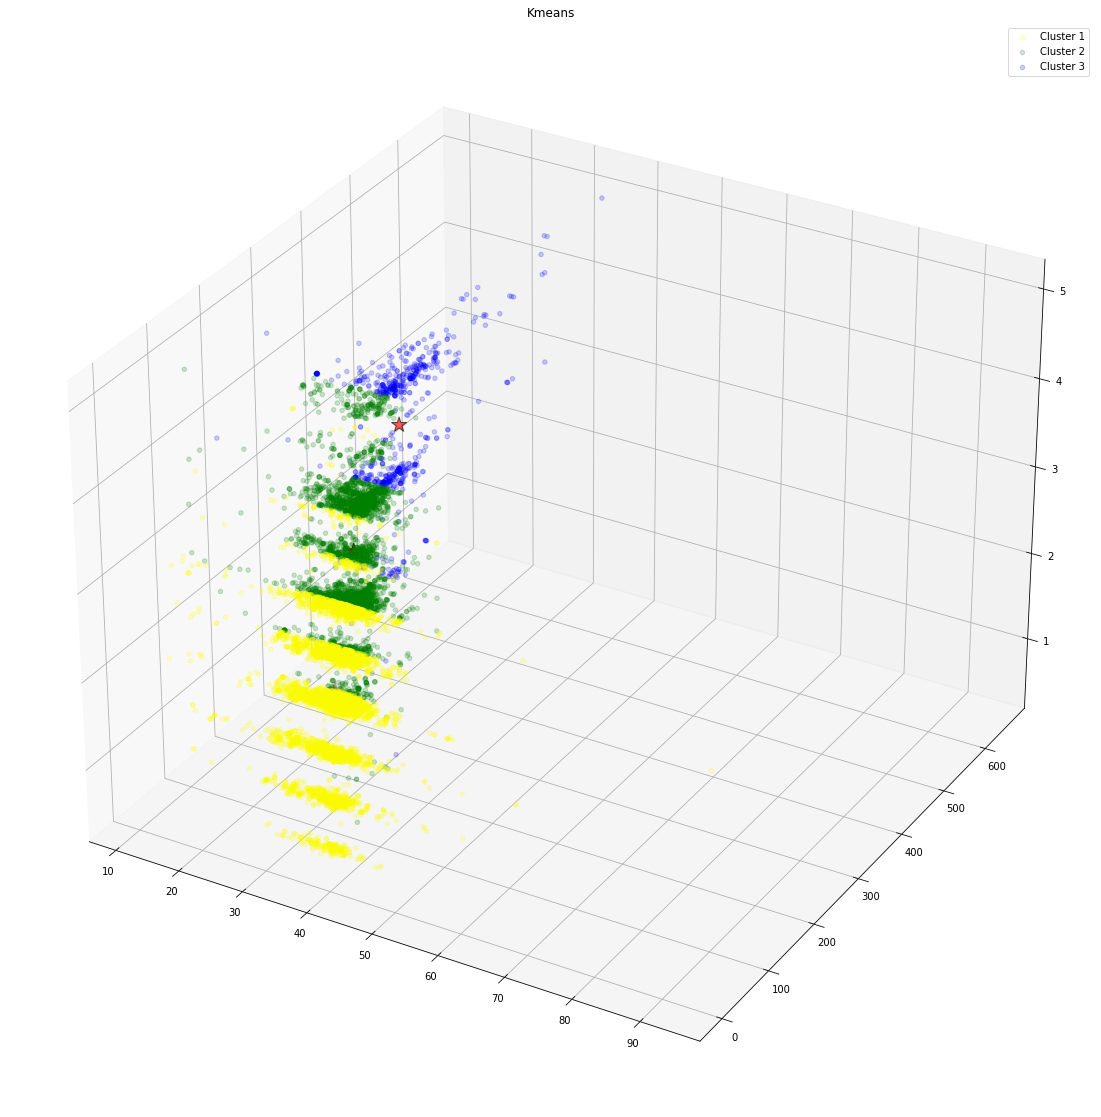

In [8]:
fig = plt.figure(figsize=(20, 20))
kplot = fig.add_subplot(111, projection='3d')
xline = np.linspace(0, 1, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
# kplot.plot3D(xline, yline, zline, 'black')
# Data for three-dimensional scattered points
kplot.scatter3D(data1.distance, data1.kvadratura, data1.broj_soba, c='yellow', label = 'Cluster 1', alpha=0.2)
kplot.scatter3D(data2.distance, data2.kvadratura, data2.broj_soba ,c ='green', label = 'Cluster 2', alpha=0.2)
kplot.scatter3D(data3.distance, data3.kvadratura, data3.broj_soba ,c ='blue', label = 'Cluster 3', alpha=0.2)
kplot.scatter3D(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], k_means_optimum.cluster_centers_[:,2], s=250, marker='*',
    c='red', edgecolor='black',)
plt.legend()
plt.title("Kmeans")
plt.show()

In [9]:
k_means_optimum.cluster_centers_[:,0]

array([37.10895195, 37.00367939, 36.87103942])

In [10]:
k_means_optimum.cluster_centers_[:,2]

array([2.14613161, 3.4810111 , 4.44210526])

In [11]:
X = X_data_new[X_data_new.columns.difference(['cluster'])]


C:\Users\busketi\AppData\Local\Temp/ipykernel_22544/1277226090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data_new['PCA1'] = pca[:, 0]
C:\Users\busketi\AppData\Local\Temp/ipykernel_22544/1277226090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data_new['PCA2'] = pca[:, 1]


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

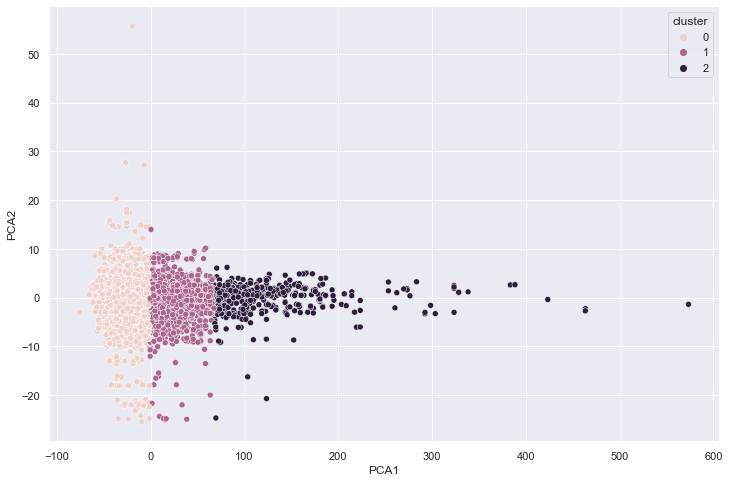

In [12]:
# Fit PCA with 2 components
pca = PCA(n_components=2).fit_transform(X_data_new)
# Add the two components as columns in the dataframe
X_data_new['PCA1'] = pca[:, 0]
X_data_new['PCA2'] = pca[:, 1]
# Visualize the data
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=X_data_new, x="PCA1", y="PCA2", hue="cluster")

Text(0, 0.5, 'Euclidean Distance')

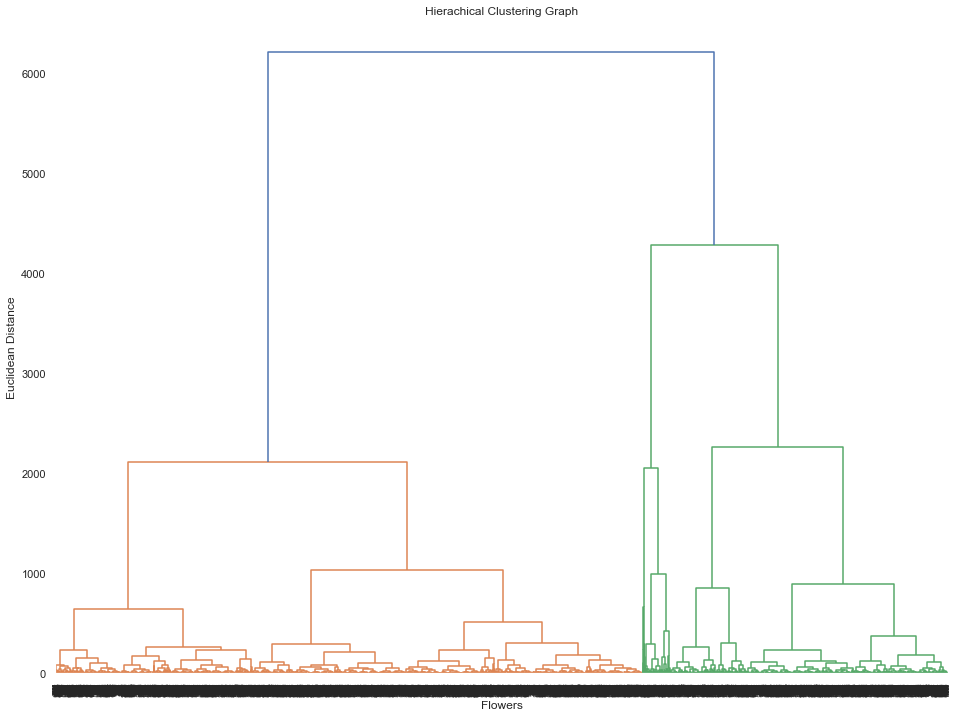

In [13]:
plt.figure(figsize=(16,12))
# Fit the heirachical graph
heirachical_graph=hier.dendrogram(hier.linkage(X_data_new, method='ward')) #method='ward' uses the Ward variance minimization algorithm
# Add titles and labels
plt.title('Hierachical Clustering Graph')
plt.xlabel('Flowers')
plt.ylabel('Euclidean Distance')